In [1]:
%matplotlib inline
import pylab as pl
from astropy import units as u, constants, visualization
visualization.quantity_support()
pl.style.use('dark_background')

# Model Fitting & Measurement in practice

AST 4723

# Measurements

We can make several measurements from the spectra we've obtained:

1. The frequency of the line
2. The intensity of the line

# Line Profiles

So what is a "spectral line" anyway?

The HI spin-flip transition is a quantum process that produces a photon at a specific frequency, and it *always* produces a photon at that frequency - in the rest frame of the particle.  (exceptions to be discussed in a later lecture)

# Line Profiles - Doppler Shift

The "line profile" we observe is caused by *doppler shift* in the line center.

The Doppler formula (in the "radio convention" approximation) is:

$$ \frac{\Delta v}{c} = \frac{\nu_{rest} - \nu_{observed}}{\nu_{rest}} $$

# Line Profiles - Doppler Shift

What causes $\nu_{observed}$ to vary, then?

Often the most important process is *thermal broadening*.

Particles in a gas move according to the Maxwell-Boltzmann Distribution

# Maxwell-Boltzmann distribution

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Simulation_of_gas_for_relaxation_demonstration.gif/450px-Simulation_of_gas_for_relaxation_demonstration.gif" style="max-height: 600px">


# Line Profiles - Maxwell-Boltzmann Distribution

The Maxwell-Boltzmann velocity vector distribution tells you how fast a particle is moving along your line-of-sight.  

$$c_s = \sqrt{\frac{k_B T}{m}}$$

$k_B$ is Boltzmann's constant, $T$ is the gas temperature, and $m$ is the particle mass.  $c_s$ is the *speed of sound*, and is the width of the Boltzmann velocity distribution for an isothermal (single-temperature) gas. 

This gives a probability distribution:

$$p(v_{los}) = \exp\left[\frac{-v_{los}^2}{2 c_s^2}\right] = \exp\left[\frac{-m v_{los}^2}{2 k_B T}\right]$$

# Line Profiles - Maxwell-Boltzmann Distribution

This is a Gaussian distribution, $f(x) \propto e^{-x^2}$:

$$p(v_{los}) = \exp\left[\frac{-v_{los}^2}{2 c_s^2}\right]$$

It tells you how many particles are moving at each velocity.  For example...

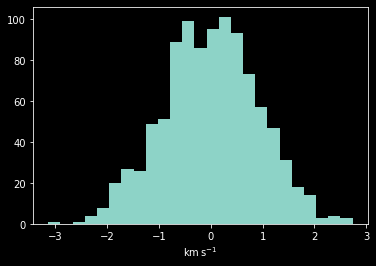

In [2]:
# Example: There are 1000 Hydrogen particles with T=100 K
temperature = 100*u.K
hydrogen_mass = 1*u.Da # a "Dalton" is equal to one Atomic Mass Unit
soundspeed = ((constants.k_B * temperature / hydrogen_mass)**0.5).to(u.km/u.s)
# sample particle velocities from a "normal" (Gaussian) distribution
particle_velocities = np.random.randn(1000) * soundspeed
_=pl.hist(particle_velocities, bins=25)

# Line Profiles - Doppler Shift

A moving particle produces a photon at a different frequency as determined by the doppler formula:

$$ \frac{\Delta v}{c} = \frac{\nu_{rest} - \nu_{moving}}{\nu_{rest}} $$

gives

$$ \nu_{moving} = \nu_{rest} \left(1 - \frac{\Delta v}{c}\right) $$

# Line Profiles - Doppler Shift
The doppler formula combined with the Boltzmann distribution gives:
$$ \frac{\Delta v}{c} = \frac{\nu_{rest} - \nu_{moving}}{\nu_{rest}} =  \frac{\nu_{rest} - \nu_{los}}{\nu_{rest}} $$

$$p(v_{los}) = \exp\left[\frac{-v_{los}^2}{2 c_s^2}\right]$$



$$ p(\nu_{los}) =  \exp\left[\frac{-\left[c(\nu_{rest}-\nu_{los})/\nu_{rest}\right]^2}{2 c_s^2}\right] $$


# Line Profiles - Doppler Shift

This is the line profile produced by an isothermal gas:

$$ p(\nu_{los}) =  \exp\left[\frac{-\left[c (\nu_{rest}-\nu_{los})/( \nu_{rest})\right]^2}{2 c_s^2}\right] $$


# Line Profile - Measurement

Most line profiles are dominated by motion and end up with Gaussian profiles.  There are other physical effects, including *pressure broadening* and *natural width* (from the Heisenberg uncertainty principle) that we'll discuss later, but for now we assume all line emission is broadened by motion.

Given that starting assumption, we can measure physical properties of the gas from the line profile.

In [3]:
# a simulated line profile
nu_hi = 1420.405751 * u.MHz
bandwidth = 2.5 * u.MHz
frequency_axis = np.linspace(nu_hi - bandwidth/2, nu_hi + bandwidth/2, 2048)
# assume we're measuring something in Janskys
model_line_profile = np.exp(-(constants.c * (nu_hi - frequency_axis)/(nu_hi * soundspeed ))**2 / 2) * u.Jy

(1420.3, 1420.5)

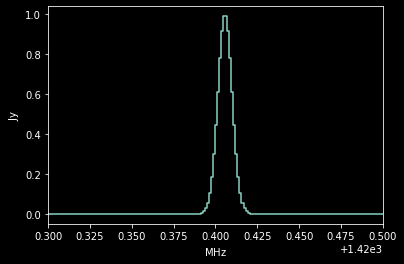

In [4]:
pl.plot(frequency_axis, model_line_profile, drawstyle='steps-mid')
pl.xlim(1420.3,1420.5)

# Line Profile - Measurement

The *width* tells us about the *velocity distribution*, which can be used to infer the temperature (in some cases).

How do we measure the width?  A few possibilities exist:
1. Eyeball it
2. Use *moment analysis*
3. Fit a model function to the data

# Line Profile - Measurement

The eyeball method: A Gaussian distribution has a well-defined width.  

The full-width at half-maximum (FWHM) is related to the width $\sigma$ as:

$$ FWHM = \sqrt{8 \ln 2}~\sigma$$

The width of a thermally broadened line is $\sigma = c_s$, so if we can estimate how wide the line is "by eye", we can get a quick estimate of the sound speed and therefore the temperature.

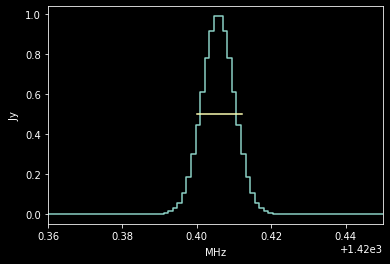

In [5]:
# drop a ruler onto the plot and measure the FWHM... you can get pretty close
pl.plot(frequency_axis, model_line_profile, drawstyle='steps-mid')
pl.xlim(1420.36,1420.45)
pl.plot([1420.4,1420.4122], [0.5,0.5])

# Line Profile - Measurement

Moment Analysis is the quickest, simplest approach. 

The *zero'th moment* is the integral of the distribution:

$$m_0 = \int p(\nu) d\nu$$


The first moment is the *centroid*:

$$m_1 = \frac{\int \nu p(\nu) d\nu}{\int p(\nu) d\nu}$$

The second *central* moment measures the width:

$$m_2 = \frac{\int (\nu - \nu_{center})^2 p(\nu) d \nu}{\int p(\nu) d\nu} $$

# Line Profile - Measurement

What does moment 0 mean?
$$m_0 = \int p(\nu) d\nu$$
In practice, we calculate this as 
$$ m_0 = \Sigma S_\nu \Delta \nu$$

$S_\nu$ is the recorded brightness value, and $\Delta \nu$ is the width of a channel.  This is the "total intensity" or "integrated intensity" and represents the total amount of light received from the line.  It will have units of "flux units" times "X-axis units"; for example, Jy Hz or K km/s.

In [6]:
delta_nu = frequency_axis[1] - frequency_axis[0]
moment0 = (model_line_profile * delta_nu).sum()
moment0

<Quantity 0.01082926 Jy MHz>

# Line Profile - Measurement

What does moment 1 mean?

$$m_1 = \frac{\int \nu p(\nu) d\nu}{\int p(\nu) d\nu}$$

In practice, we calculate this as 

$$m_1 = \frac{\Sigma \nu S_\nu \Delta \nu}{m_0}$$

$m_1$ is the *weighted average* of the X-axis $\nu$.  It has the same units as $\nu$ - frequency.

In [7]:
moment1 = (frequency_axis * model_line_profile * delta_nu).sum() / moment0
moment1

<Quantity 1420.405751 MHz>

# Line Profile - Measurement

What does moment 2 mean?
$$m_2 = \frac{\int (\nu - \nu_{center})^2 p(\nu) d \nu}{\int p(\nu) d\nu} $$
In practice, we calculate this as 
$$m_2 = \frac{\Sigma \left(\nu - m_1\right)^2 S_\nu \Delta \nu}{m_0}$$
$m_2$ is the *intensity-weighted variance*.  It has units $[\nu]^2$.  Recall that *variance* is the square of the *standard deviation*.  The *Gaussian width* $\sigma=m_2^{1/2}$.

We subtract out $m_1$ from each frequency because we're calculating the variance around a central point.

In [8]:
moment2 = ( (frequency_axis - moment1)**2 * model_line_profile * delta_nu).sum() / moment0
sigma = moment2**0.5
moment2, sigma

(<Quantity 1.86645543e-05 MHz2>, <Quantity 0.00432025 MHz>)

# Line Profile Measurement - moments usually work

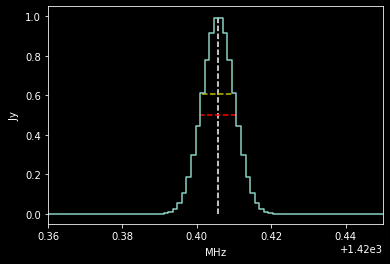

In [9]:
pl.plot(frequency_axis, model_line_profile, drawstyle='steps-mid')
pl.xlim(1420.36,1420.45)
pl.vlines(moment1, 0*u.Jy, 1*u.Jy, color='w', linestyle='--')
# the Gaussian width is the half-width at exp(-1/2)
pl.hlines( np.exp(-0.5), moment1-sigma, moment1+sigma, color='y', linestyle='--')
pl.hlines( 0.5, moment1-sigma*2.35/2, moment1+sigma*2.35/2, color='r', linestyle='--');

# Line Profile Measurements - what about noise?

Even in the presence of noise, moment analysis is very effective - but it can go awry.

In [10]:
np.random.seed(0)
uncertainty = 0.1 * model_line_profile.unit
noisy_model_profile = model_line_profile + uncertainty * np.random.randn(model_line_profile.size)

(1420.33, 1420.48)

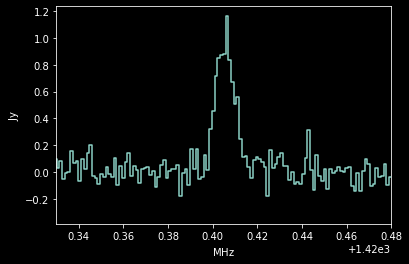

In [11]:
pl.plot(frequency_axis, noisy_model_profile, drawstyle='steps-mid')
pl.xlim(1420.33,1420.48);

In [12]:
noisy_moment0 = noisy_model_profile.sum() * delta_nu
noisy_moment1 = (frequency_axis * noisy_model_profile * delta_nu).sum() / noisy_moment0
noisy_moment2 = ( (frequency_axis - noisy_moment1)**2 * noisy_model_profile * delta_nu).sum() / noisy_moment0
noisy_sigma = noisy_moment2**0.5
noisy_moment0, noisy_moment1, noisy_moment2, noisy_sigma

/home/adam/repos/astropy/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<Quantity 0.00707108 Jy MHz>,
 <Quantity 1420.86404663 MHz>,
 <Quantity -0.43715543 MHz2>,
 <Quantity nan MHz>)

What happened?  The centroid is wrong, and the noise won out over the signal.


If we re-measure over a subset... if we "crop" the spectrum.... we can get a reasonable answer again:

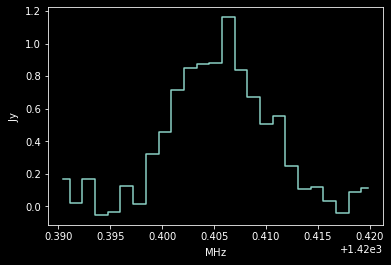

In [13]:
selection = ((frequency_axis > 1420.39 * u.MHz) &
             (frequency_axis < 1420.42*u.MHz))
pl.plot(frequency_axis[selection],
        noisy_model_profile[selection], drawstyle='steps-mid')

In [14]:
noisy_moment0 = noisy_model_profile[selection].sum() * delta_nu
noisy_moment1 = (frequency_axis[selection] * noisy_model_profile[selection] * delta_nu).sum() / noisy_moment0
noisy_moment2 = ( (frequency_axis[selection] - noisy_moment1)**2 * noisy_model_profile[selection] * delta_nu).sum() / noisy_moment0
noisy_sigma = noisy_moment2**0.5
noisy_moment0, noisy_moment1, noisy_moment2, noisy_sigma

(<Quantity 0.01088147 Jy MHz>,
 <Quantity 1420.40551509 MHz>,
 <Quantity 2.4993493e-05 MHz2>,
 <Quantity 0.00499935 MHz>)

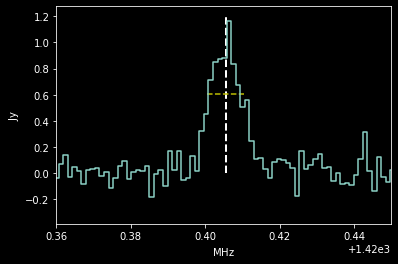

In [15]:
pl.plot(frequency_axis, noisy_model_profile, drawstyle='steps-mid')
pl.xlim(1420.36,1420.45)
pl.vlines(noisy_moment1, 0*u.Jy, 1.2*u.Jy, color='w', linestyle='--', linewidth=2)
# the Gaussian width is the half-width at exp(-1/2)
pl.hlines(np.exp(-0.5), noisy_moment1-noisy_sigma, noisy_moment1+noisy_sigma, color='y', linestyle='--');

# Moment Analysis - Physical inference

What do the various moments tell us about the thing we're looking at?

Moment 0 is the integrated intensity.  It's how much light we get.

Moment 1 is the line-of-sight velocity:

In [16]:
v_los_measured = (nu_hi - moment1) / nu_hi  * constants.c
noisy_v_los_measured = (nu_hi - noisy_moment1) / nu_hi  * constants.c
v_los_measured, noisy_v_los_measured

(<Quantity -4.79897473e-08 m / s>, <Quantity 49.79126441 m / s>)

# Moment Analysis - Physical inference

Moment 2 is related to the *line width*, which in turn relates to the temperature (if the line is only thermally broadened).
$$ c_s = \sigma_v = \sqrt{\frac{k_B T}{m_H}} $$
So the temperature is:
$$ T = \frac{\sigma_v^2 m_H}{k_B} = \frac{m_{2,v} m_H}{k_B} $$
But we measured $\sigma_\nu$, the width in frequency.  
$$ \frac{\sigma_\nu}{\nu} = \frac{\sigma_v}{c}$$

So, we solve for $\sigma_v = c \sigma_\nu / \nu$ and plug in...

$$ T = \frac{\sigma_v^2 m_H}{k_B} = \frac{\sigma_\nu^2 c^2 m_H}{\nu^2 k_B} = \frac{m_{2,\nu} c^2 m_H}{\nu^2 k_B} $$


In [17]:
moment2_v = (moment2 / nu_hi**2) * constants.c**2
noisy_moment2_v = (noisy_moment2 / nu_hi**2) * constants.c**2
temperature_measured = (moment2_v * hydrogen_mass / constants.k_B).to(u.K)
noisy_temperature_measured = (noisy_moment2_v * hydrogen_mass / constants.k_B).to(u.K)
temperature_measured, noisy_temperature_measured

(<Quantity 100. K>, <Quantity 133.90886615 K>)

So we've recovered the temperature!

# Moment Analysis - Physical inference

This sort of measurement is at the heart of remote sensing and astrophysical spectroscopy:



From measuring properties of an emission line, the photons produced by a gas, we can infer the *local properties* of that gas.



We can "take the temperature" of a gas cloud anywhere in the universe just by measuring simple properties of its emitted spectrum!



(of course, we made some simplifying assumptions; for cold gas, usually the line width is broader than thermal)

# Moment analysis - what about uncertainty?

You knew it was coming, right?

We need to know what the uncertainty is on our measurements.  The uncertainty for these calculations follows the same sum-in-quadrature as with other Gaussian-noise-affected measurements.

We'll keep this brief for now...

# Moment 0 error

We have an error per channel $\sigma_S$; unfortunately, we use the same symbol ($\sigma$) for both uncertainty distribution width and line width - you just have to be explicit and clear about what you mean!

$$ m_0 = \Sigma S_\nu \Delta \nu $$

This becomes, assuming a uniform noise (every channel / pixel has the same uncertainty) $\sigma_S$:

$$ \sigma_{m_0}^2 = \Sigma \sigma_S^2 (\Delta \nu)^2 = N (\Delta \nu)^2 \sigma_S^2 $$

where $N$ is the number of channels.

In [18]:
noisy_moment0 = (noisy_model_profile[selection] * delta_nu).sum()
Npts = noisy_model_profile[selection].size
noisy_moment0_uncertainty = (Npts * delta_nu**2 * (uncertainty**2))**0.5
f"m0 = {noisy_moment0:0.3f} +/- {noisy_moment0_uncertainty:0.3f}"

'm0 = 0.011 Jy MHz +/- 0.001 Jy MHz'

# Moment 1 error


$$ m_1 = \frac{\Sigma \nu S_\nu \Delta \nu}{m_0} $$

There is no uncertainty on $\nu$ - we know exactly what freqency each bin is.


The propagation of uncertainty formulae come from Taylor expansion around the central moment, so when we calculate the uncertainty, we subtract off the centroid measurement $\nu_0 \approx m_1$ first.

These propagations-of-uncertainty are approximations.


The numerator of the  $m_1$ equation is $$\Sigma (\nu - \nu_{center}) S_\nu \Delta \nu$$.

We take advantage of the propagation of errors for sums $$\sigma^2(\Sigma x_i) = \Sigma \sigma_{x_i}^2$$ to write the error on the numerator as

$$ \sigma_{numerator}^2 = \Sigma \left[(\nu-m_1) \sigma_S \Delta \nu\right]^2 = \Sigma (\nu-m_1)^2 \sigma_S^2 (\Delta \nu)^2 $$


For an equation like $z = y/x$, we use $ \frac{\sigma_z^2}{z^2} = \frac{\sigma_y^2}{y^2} + \frac{\sigma_x^2}{x^2}$ to propagate error, where $y$ is the numerator and $x$ is the denominator.

$$ \sigma_{numerator}^2 = \Sigma (\nu-m_1)^2 \sigma_S^2 (\Delta \nu)^2 $$

and $\sigma_{denominator} = \sigma_{m_0}$, so we get:

$$\sigma_{m_1}^2 =  \left(\frac{\Sigma (\nu-m_1)^2  (\Delta \nu)^2 \sigma_S^2}{m_0^2}  +
   \frac{\sigma_{m_0}^2 \Sigma (\nu-m_1)^2 S_\nu^2 (\Delta \nu)^2}{m_0^4} \right)$$


In [19]:
left_term = ((delta_nu * uncertainty * (frequency_axis[selection] - noisy_moment1))**2).sum() / noisy_moment0**2
right_term = (noisy_moment0_uncertainty**2 * (((frequency_axis[selection] - noisy_moment1) * 
                                              noisy_model_profile[selection] * delta_nu)**2).sum()) / noisy_moment0**4
noisy_moment1_uncertainty = (left_term + right_term)**0.5
    
f"m1 = {noisy_moment1:0.4f} +/- {noisy_moment1_uncertainty:0.4f}"

'm1 = 1420.4055 MHz +/- 0.0005 MHz'

That formula is complicated.  To avoid writing it multiple times, and to simplify it a little bit, we write it out as a function:

In [20]:
def moment1_uncertainty(xaxis, data, uncertainty):
    deltax = xaxis[1] - xaxis[0]
    moment0 = (data * deltax).sum()
    moment0_uncertainty = (len(data) * deltax**2 * (uncertainty**2))**0.5
    moment1 = (data * xaxis * deltax).sum() / moment0
    left_term = ((deltax * uncertainty * (xaxis - moment1))**2).sum() / moment0**2
    right_term = (moment0_uncertainty**2 *
                  (((xaxis - moment1) * data * delta_nu)**2).sum()) / moment0**4
    moment1_uncertainty = (left_term + right_term)**0.5
    return moment1, moment1_uncertainty

In [21]:
moment1_uncertainty(frequency_axis[selection], noisy_model_profile[selection], uncertainty)

(<Quantity 1420.40551509 MHz>, <Quantity 0.00049757 MHz>)

# Moment 2 error
$$m_2 = \frac{\Sigma \left(\nu - m_1\right)^2 S_\nu \Delta \nu}{m_0}$$

We just invoke symmetry here (in other words, I cheated on the algebra, but it's a fair cheat) and replace all $\nu$ (or $\nu-m_1$) terms with $\nu^2$.

$$\sigma_{m_2}^2 =  \left(\frac{\Sigma (\nu-m_1)^4  (\Delta \nu)^2 \sigma_S^2}{m_0^2}  +
   \frac{\sigma_{m_0}^2 \Sigma (\nu-m_1)^4 S_\nu^2 (\Delta \nu)^2}{m_0^4} \right)$$

In [22]:
left_term = ((delta_nu * uncertainty * (frequency_axis[selection] - noisy_moment1)**2)**2).sum() / noisy_moment0**2
right_term = (noisy_moment0_uncertainty**2 * (((frequency_axis[selection] - noisy_moment1)**2 * 
                                              noisy_model_profile[selection] * delta_nu)**2).sum()) / noisy_moment0**4
noisy_moment2_uncertainty = (left_term + right_term)**0.5
    
f"m2 = {noisy_moment2**0.5:0.4f} +/- {noisy_moment2_uncertainty**0.5:0.4f}"

'm2 = 0.0050 MHz +/- 0.0024 MHz'

In [23]:
# again, simplify this into a function
def moment2_uncertainty(xaxis, data, uncertainty):
    deltax = xaxis[1] - xaxis[0]
    moment0 = (data * deltax).sum()
    moment0_uncertainty = (len(data) * deltax**2 * (uncertainty**2))**0.5
    moment1 = (data * xaxis * deltax).sum() / moment0
    left_term = ((deltax * uncertainty * (xaxis - moment1)**2)**2).sum() / moment0**2
    right_term = (moment0_uncertainty**2 *
                  (((xaxis - moment1)**2 * data * delta_nu)**2).sum()) / moment0**4
    moment2_uncertainty = (left_term + right_term)**0.5
    moment2 = ((xaxis-moment1)**2 * deltax * data).sum() / moment0
    return moment2, moment2_uncertainty

In [24]:
m2,m2u = moment2_uncertainty(frequency_axis[selection], noisy_model_profile[selection], uncertainty)
f"m2 = {m2**0.5:0.4f} +/- {m2u**0.5:0.4f}"

'm2 = 0.0050 MHz +/- 0.0024 MHz'

# Summarizing moment uncertainties

In [25]:
print(f"m0 = {noisy_moment0:0.4f} +/- {noisy_moment0_uncertainty:0.4f}, S/N={noisy_moment0/noisy_moment0_uncertainty:0.1f}")
print(f"m1 = {noisy_moment1:0.4f} +/- {noisy_moment1_uncertainty:0.4f}")
print(f"m2 = {noisy_moment2:0.4g} +/- {noisy_moment2_uncertainty:0.4g}")
print(f"sqrt(m2) = {noisy_moment2**0.5:0.4f} +/- {noisy_moment2_uncertainty**0.5:0.4f}")

m0 = 0.0109 Jy MHz +/- 0.0006 Jy MHz, S/N=17.8
m1 = 1420.4055 MHz +/- 0.0005 MHz
m2 = 2.499e-05 MHz2 +/- 5.866e-06 MHz2
sqrt(m2) = 0.0050 MHz +/- 0.0024 MHz


Note there is an asymmetry here: moment 0 has a signal-to-noise of about 20, moment 2 has a signal-to-noise of about 2, but moment1 appears to have a HUGE signal-to-noise ratio.  That's not really right, because what we're actually measuring is the deviation from moment1.  Moment 1 makes more sense if expressed in velocity...

In [26]:
m1_velocity = (nu_hi - noisy_moment1) / nu_hi * constants.c
m1_velocity_uncertainty = noisy_moment1_uncertainty / nu_hi * constants.c
print(f"m1 = {m1_velocity:0.1f} +/- {m1_velocity_uncertainty:0.1f}")

m1 = 49.8 m / s +/- 105.0 m / s


This measurement now appears to have S/N < 1 - that's telling us that our measured moment 1 is consistent with zero velocity.  That makes sense, since the input model has zero velocity!

FIN for now

# Moment Analysis - Physical inference *with uncertainty*

The temperature is, from above:
$$ T = \frac{\sigma_v^2 m_H}{k_B} = \frac{m_{2,v} m_H}{k_B} = \frac{m_{2,\nu} m_H c^2}{k_B \nu^2}$$

# Moment Analysis - Physical inference *with uncertainty*

The temperature is, from above:
$$ T = \frac{\sigma_v^2 m_H}{k_B} = \frac{m_{2,v} m_H}{k_B} = \frac{m_{2,\nu} m_H c^2}{k_B \nu^2}$$

In [27]:
# estimate of the temperature and uncertainty on the temperature
noisy_temperature_measured = (noisy_moment2 * constants.c**2 * hydrogen_mass / (nu_hi**2 * constants.k_B)).to(u.K)
noisy_temperature_uncertainty = (noisy_moment2_uncertainty * constants.c**2 * hydrogen_mass / (nu_hi**2 * constants.k_B)).to(u.K)
print(f"T = {noisy_temperature_measured:0.1f} +/- {noisy_temperature_uncertainty:0.1f}")

T = 133.9 K +/- 30.7 K


# Moment Analysis - baselines

Where can moment analysis go really wrong?

If you have a background continuum, none of this works!  We call removing the continuum "baseline subtraction".

We'll dig into baselines more now as it's important for the cases we're dealing with.

(-0.2, 2.5)

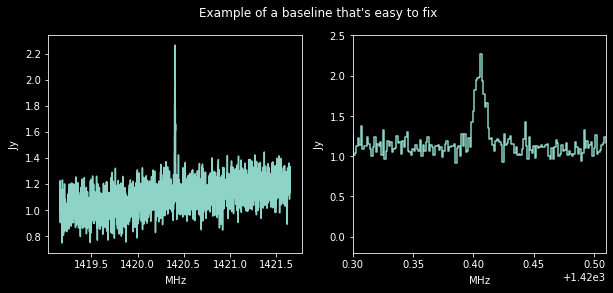

In [28]:
noisy_baseline_model_profile = noisy_model_profile + np.poly1d([0.0001,1],r=False)(np.arange(frequency_axis.size))*noisy_model_profile.unit
pl.figure(figsize=(10,4))
pl.suptitle("Example of a baseline that's easy to fix")
pl.subplot(1,2,1).plot(frequency_axis, noisy_baseline_model_profile,
        drawstyle='steps-mid')
pl.subplot(1,2,2).plot(frequency_axis, noisy_baseline_model_profile,
        drawstyle='steps-mid')
pl.xlim(1420.3,1420.51)
pl.ylim(-0.2,2.5)


Why is the baseline a problem?
$$ m_0 = \Sigma  S_\nu \Delta \nu $$
$$ m_1 = \frac{\Sigma \nu S_\nu \Delta \nu}{m_0} $$
$$ m_2 = \frac{\Sigma \nu^2 S_\nu \Delta \nu}{m_0} $$
All of these moments include the flux at each pixel, so if there's a gradient in the flux, it biases the measurement.

In [29]:
# hackery to make a bad baseline example
# (you don't need to pay close attention to this for now)
np.random.seed(2)
x = np.poly1d([1,2,3] + list(np.random.randn(25)))(np.linspace(-5,5,frequency_axis.size))
x = np.abs(np.fft.fft(x)) / x.sum()
x[0:18] = 0
bad_baseline = np.abs(np.fft.fft(x)) * model_line_profile.unit
noisy_bad_baseline_model_profile = noisy_model_profile + bad_baseline

# Real Bad Baselines

In real life, bad baselines can be really bad, and important (and difficult) to deal with...

<img src="images/41550_2020_1174_Fig9_ESM.webp">

(-0.2, 2.0)

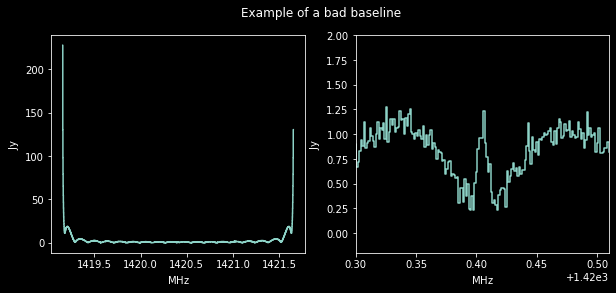

In [30]:
pl.figure(figsize=(10,4))
pl.suptitle("Example of a bad baseline")
pl.subplot(1,2,1).plot(frequency_axis, noisy_bad_baseline_model_profile,
        drawstyle='steps-mid')
pl.subplot(1,2,2).plot(frequency_axis, noisy_bad_baseline_model_profile,
        drawstyle='steps-mid')
pl.xlim(1420.3,1420.51)
pl.ylim(-0.2,2.)


## What do we do about bad baselines?

Generally, we try to model and remove them.  

This can be difficult and can result in fake features in the data, so it helps to know what fake features look like.


When you take spectra with the resistor attached, or with the antenna not attached, it is telling you what the instrumental features look like.

Text(0.5, 1.0, 'Example of a spectrum with a bad baseline from our data')

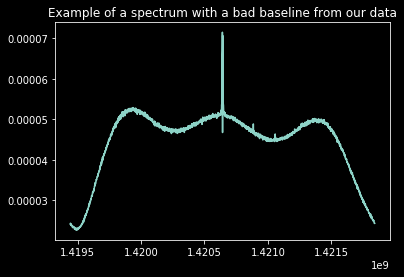

In [31]:
from astropy import table
tbl = table.Table.read('data/psd_200918_140757_tint60s_sdr0_fsw50ohm_on_calibration_60s.fits')
pl.plot(tbl['freq1'], tbl['power1'])
pl.title("Example of a spectrum with a bad baseline from our data")

We're just noting baselines as a problem now - we'll come back to how to subtract them in a few slides.

# Model Fitting

The next level approach is to fit a model to the data.

Our model is a "predictive" or "generative" model.

When fitting the model to data, in the "classical" approach, we treat the uncertainty-per-pixel as a weight.

Text(0.5, 1.0, 'A line profile with errorbars')

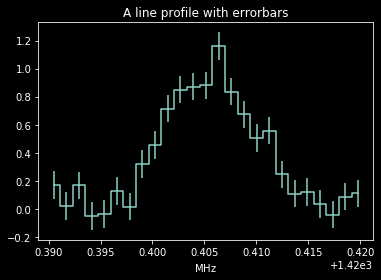

In [32]:
# a line profile with errorbars on the data points
pl.errorbar(frequency_axis[selection], noisy_model_profile[selection].value,
            drawstyle='steps-mid', yerr=noise_estimate.value)
pl.title("A line profile with errorbars")

# Model Fitting

Astropy provides the tools for this.  Programming your own fitting (optimization) routine is very challenging, so we use existing libraries.

https://docs.astropy.org/en/stable/modeling/

# Model Fitting

Our emission line is expected to be a Gaussian, so we adopt that model.

In [33]:
from astropy.modeling.models import Gaussian1D

We have to start our modeling from a guess.  We'll use our moment-based guesses as the inputs:

In [34]:
# create a Gaussian model
guess_gaussian = Gaussian1D(amplitude=noisy_model_profile.max(),
                            mean=noisy_moment1,
                            stddev=noisy_sigma
                           )
guess_gaussian

<Gaussian1D(amplitude=1.16129091 Jy, mean=1420.40551509 MHz, stddev=0.00499935 MHz)>

# Using models

We can evaluate our model by using it as a function: `guess_gaussian(frequency)` will give us a new model:

Text(0.5, 1.0, 'our Gaussian model plotted on top of the data')

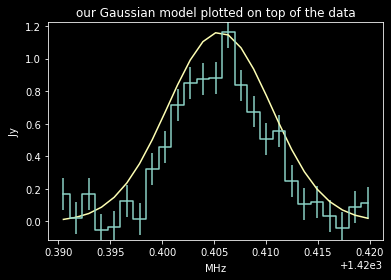

In [35]:
pl.errorbar(frequency_axis[selection], noisy_model_profile[selection].value,
            drawstyle='steps-mid', yerr=noise_estimate.value)
pl.plot(frequency_axis[selection], guess_gaussian(frequency_axis[selection]))
pl.title("our Gaussian model plotted on top of the data")

# Fitting

We now want to *fit* the model: we want to use an automated algorithm to find the best-matching set of parameters for the Gaussian.

In [36]:
# import the Levenberg-Marquardt Least Squares Model Fitter
from astropy.modeling.fitting import LevMarLSQFitter
fitter = LevMarLSQFitter()
fitted_gaussian = fitter(guess_gaussian, frequency_axis, noisy_model_profile,
                         weights=1/noise_estimate)
fitted_gaussian

<Gaussian1D(amplitude=1.00337362 Jy, mean=1420.40555747 MHz, stddev=0.00418435 MHz)>

# Fitting
Now that we've found the fit, let's look at how well it did:

(1420.36, 1420.45)

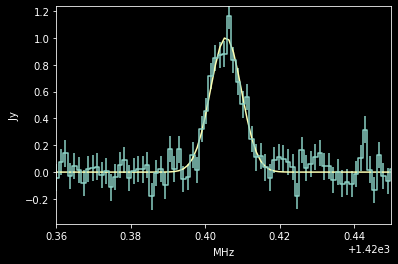

In [37]:
pl.errorbar(frequency_axis, noisy_model_profile.value,
            drawstyle='steps-mid', yerr=noise_estimate.value)
pl.plot(frequency_axis, fitted_gaussian(frequency_axis))
pl.xlim(1420.36,1420.45)

# Fitting: Good enough?

How do we determine if the fit is good enough?  One good way is to look at the residuals.

Residuals are the *data* minus the *model*:

In [38]:
model = fitted_gaussian(frequency_axis)

residual = noisy_model_profile - model

(1420.36, 1420.45)

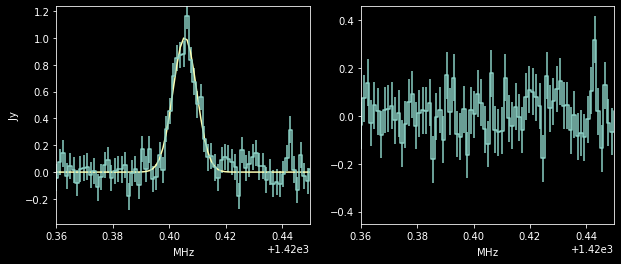

In [39]:
pl.figure(figsize=(10,4))
pl.subplot(1,2,1).errorbar(frequency_axis, noisy_model_profile.value,
            drawstyle='steps-mid', yerr=noise_estimate.value)
pl.plot(frequency_axis, fitted_gaussian(frequency_axis))
pl.xlim(1420.36,1420.45)
pl.subplot(1,2,2).errorbar(frequency_axis, residual.value,
            drawstyle='steps-mid', yerr=noise_estimate.value)
pl.xlim(1420.36,1420.45)

# Uncertainty?

The Levenberg-Marquardt fitter gives us an estimate of the parameter uncertainty too, via the covariance matrix:

In [40]:
print(fitter.fit_info['param_cov'])

[[ 2.36438876e-03  1.01223102e-17 -6.56925099e-06]
 [ 1.01223102e-17  5.47562981e-08 -2.98060611e-20]
 [-6.56925099e-06 -2.98060611e-20  5.47562981e-08]] 1 / Jy2


The diagonal of this matrix is the variance of the *amplitude*, *mean* (centroid, moment 1), and *Gaussian standard deviation* (sigma, width):

In [41]:
print(f"Peak is {fitted_gaussian.amplitude.value} +/-"
      f" {fitter.fit_info['param_cov'][0,0].value**0.5}")

Peak is 1.0033736158788507 +/- 0.04862498079580134


In [42]:
print(f"Centroid is {fitted_gaussian.mean.value} +/-"
      f" {fitter.fit_info['param_cov'][1,1].value**0.5}")

Centroid is 1420.4055574725355 +/- 0.00023400063696660042


In [43]:
print(f"Width is {fitted_gaussian.stddev.value} +/-"
      f" {fitter.fit_info['param_cov'][2,2].value**0.5}")

Width is 0.004184349993521919 +/- 0.00023400063696731637


# How do these compare to the moment-based fits?

Close, but not exact.

In [44]:
print(f"Centroid is {fitted_gaussian.mean.value:0.5f} +/- {fitter.fit_info['param_cov'][1,1]**0.5:0.5f}")
print(f"Width is {fitted_gaussian.stddev.value:0.5f} +/- {fitter.fit_info['param_cov'][2,2]**0.5:0.5f}")
print()
print(f"m1 = {noisy_moment1:0.5f} +/- {noisy_moment1_uncertainty:0.5f}")
print(f"sqrt(m2) = {noisy_moment2**0.5:0.5f} +/- {noisy_moment2_uncertainty**0.5:0.5f}")

Centroid is 1420.40556 +/- 0.00023 1 / Jy
Width is 0.00418 +/- 0.00023 1 / Jy

m1 = 1420.40552 MHz +/- 0.00049 MHz
sqrt(m2) = 0.00500 MHz +/- 0.00239 MHz


# Model Fitting - How do we handle baselines?

I noted above that bad baselines are an issue.  

For most baseline problems, you can select down a local region and fit a line around that

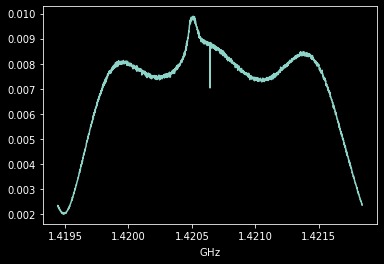

In [45]:
# our data
tbl = table.Table.read('data/psd_200725_100309_tint60s_sdr0_fsw.fits')
frq = (tbl['freq1']*u.Hz).to(u.GHz)
powr = tbl['power1']
pl.plot(frq, powr)

(<Quantity 1.42025 GHz>, <Quantity 1.4207 GHz>, 0.007, 0.01)

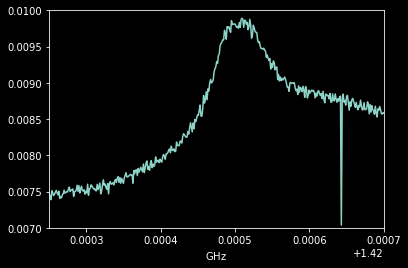

In [46]:
# zoom in on the line
pl.plot(frq.to(u.GHz), powr)
pl.axis((1.42025*u.GHz, 1.4207*u.GHz, 0.007, 0.01))

We can eyeball a linear fit to this.... it won't be good, but it will be OK:

(<Quantity 1.42025 GHz>, <Quantity 1.4207 GHz>, 0.007, 0.01)

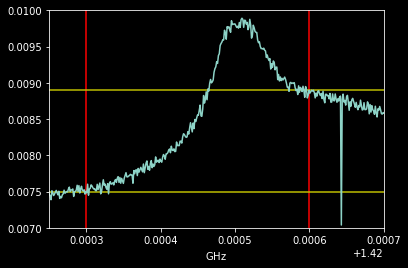

In [47]:
# let's find some approximate positions that are not part of the line...
pl.plot(frq.to(u.GHz), powr)
pl.vlines([1.4203, 1.4206]*u.GHz, 0.007, 0.01, color='r')
pl.hlines([0.0075, 0.0089], 1.42025*u.GHz, 1.4207*u.GHz, color='y')
pl.axis((1.42025*u.GHz, 1.4207*u.GHz, 0.007, 0.01))

Two points make a line... ($y = m x + b$)

In [48]:
slope = (0.0089 - 0.0075) / ((1.4206 - 1.4203)*u.GHz)
intercept = 0.0089 - slope * 1.4206*u.GHz
baseline_model = frq*slope + intercept

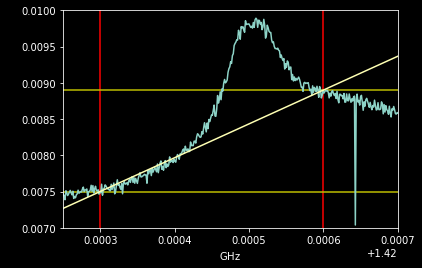

In [49]:
# show our "fit"
pl.plot(frq.to(u.GHz), powr)
pl.vlines([1.4203, 1.4206]*u.GHz, 0.007, 0.01, color='r')
pl.hlines([0.0075, 0.0089], 1.42025*u.GHz, 1.4207*u.GHz, color='y')
pl.axis((1.42025*u.GHz, 1.4207*u.GHz, 0.007, 0.01))
pl.plot(frq, baseline_model)

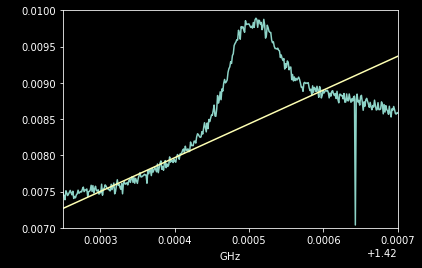

In [50]:
pl.plot(frq.to(u.GHz), powr)
pl.axis((1.42025*u.GHz, 1.4207*u.GHz, 0.007, 0.01))
pl.plot(frq, baseline_model)

We can now remove the baseline and see how that looks...

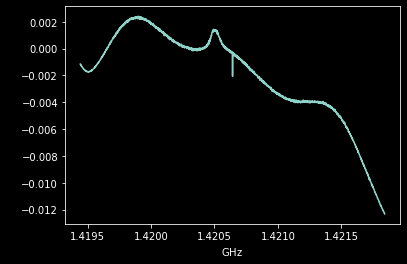

In [51]:
# Overall, this looks kinda bad....
blsub_powr = powr - baseline_model
pl.plot(frq.to(u.GHz), blsub_powr)

(-0.002, 0.002)

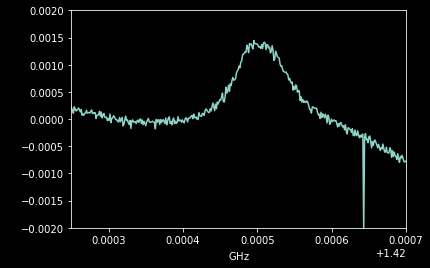

In [52]:
# but if we zoom in, hey, not so bad!!
pl.plot(frq.to(u.GHz), blsub_powr)
pl.xlim(1.42025*u.GHz, 1.4207*u.GHz)
pl.ylim(-0.002, 0.002)

We can fit a Gaussian to this now (we could not have before!!)

We need to put in some guesses.  This time, we'll eyeball them again...

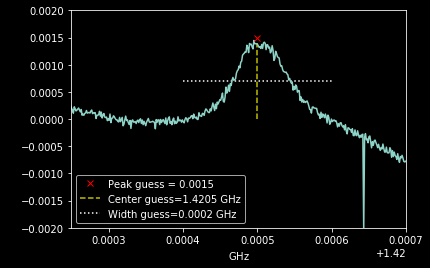

In [53]:
pl.plot(frq.to(u.GHz), blsub_powr)
pl.xlim(1.42025*u.GHz, 1.4207*u.GHz)
pl.ylim(-0.002, 0.002)
pl.plot(1.4205*u.GHz, 0.0015, 'rx', label='Peak guess = 0.0015')
pl.vlines(1.4205*u.GHz, 0, 0.0014, color='y', linestyle='--', label='Center guess=1.4205 GHz')
pl.hlines(0.0007, 1.4204*u.GHz, 1.4206*u.GHz, color='w', linestyle=':', label="Width guess=0.0002 GHz")
pl.legend(loc='best')

In [54]:
guess_gaussian = Gaussian1D(amplitude=0.0015,
                            mean=1.4205*u.GHz,
                            stddev=0.0002*u.GHz,
                           )
guess_gaussian

<Gaussian1D(amplitude=0.0015, mean=1.4205 GHz, stddev=0.0002 GHz)>

In [55]:
fitted_gaussian = fitter(guess_gaussian, frq, blsub_powr)
fitted_gaussian

<Gaussian1D(amplitude=0.00074854 , mean=1.42024623 GHz, stddev=0. GHz)>

(-0.002, 0.002)

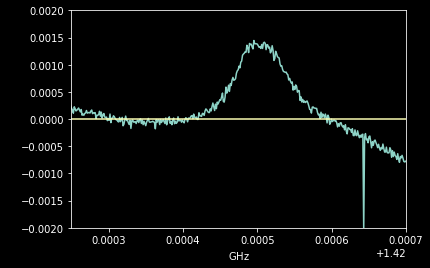

In [56]:
# uh oh! no good!
pl.plot(frq.to(u.GHz), blsub_powr)
pl.plot(frq, fitted_gaussian(frq))
pl.xlim(1.42025*u.GHz, 1.4207*u.GHz)
pl.ylim(-0.002, 0.002)

Because so much of the spectrum is not good - we only have a decent linear baseline near the line - we need to exclude the rest.  This is the "data selection" approach from before

In [57]:
selection = (frq > 1.4203*u.GHz) & (frq < 1.4207*u.GHz)

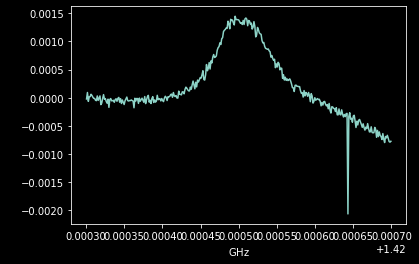

In [58]:
pl.plot(frq[selection], blsub_powr[selection])

In [59]:
guess_gaussian

<Gaussian1D(amplitude=0.0015, mean=1.4205 GHz, stddev=0.0002 GHz)>

In [60]:
fitted_gaussian = fitter(guess_gaussian, frq[selection], blsub_powr[selection])
fitted_gaussian

<Gaussian1D(amplitude=0.00075683 , mean=1.42046677 GHz, stddev=0. GHz)>

Wait, it still didn't work?  What's going wrong now?

Well,  lets look at our guess:

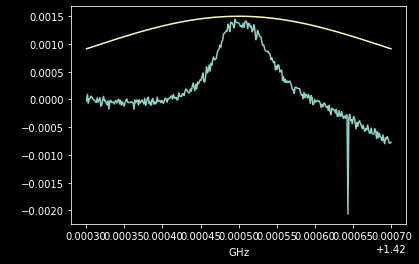

In [61]:
pl.plot(frq[selection], blsub_powr[selection])
pl.plot(frq[selection], guess_gaussian(frq[selection]))

The guess is clearly too wide!  I actually made a mistake - the width we were supposed to guess is 0.0001 GHz, not 0.0002!

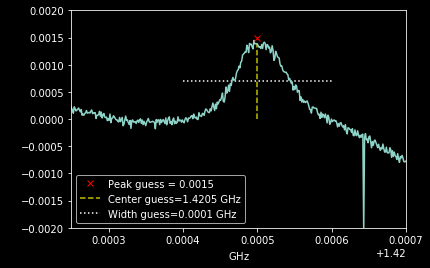

In [62]:
# This is where I overestimated the width: I put in 0.0002,
# which is the *full width*, but the guess is the *half-width*
pl.plot(frq.to(u.GHz), blsub_powr)
pl.xlim(1.42025*u.GHz, 1.4207*u.GHz)
pl.ylim(-0.002, 0.002)
pl.plot(1.4205*u.GHz, 0.0015, 'rx', label='Peak guess = 0.0015')
pl.vlines(1.4205*u.GHz, 0, 0.0014, color='y', linestyle='--', label='Center guess=1.4205 GHz')
pl.hlines(0.0007, 1.4204*u.GHz, 1.4206*u.GHz, color='w', linestyle=':', label="Width guess=0.0001 GHz")
pl.legend(loc='best')

In [63]:
guess_gaussian = Gaussian1D(amplitude=0.0015,
                            mean=1.4205*u.GHz,
                            stddev=0.0001*u.GHz,
                           )
guess_gaussian

<Gaussian1D(amplitude=0.0015, mean=1.4205 GHz, stddev=0.0001 GHz)>

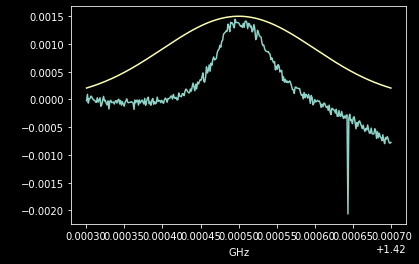

In [64]:
pl.plot(frq[selection], blsub_powr[selection])
pl.plot(frq[selection], guess_gaussian(frq[selection]))

Still a bit wide... 

In [65]:
guess_gaussian = Gaussian1D(amplitude=0.0015,
                            mean=1.4205*u.GHz,
                            stddev=0.00005*u.GHz,
                           )
guess_gaussian

<Gaussian1D(amplitude=0.0015, mean=1.4205 GHz, stddev=0.00005 GHz)>

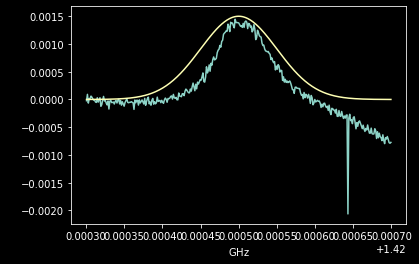

In [66]:
pl.plot(frq[selection], blsub_powr[selection])
pl.plot(frq[selection], guess_gaussian(frq[selection]))

Now that the guess is reasonably close, we can try to fit again...

In [67]:
fitted_gaussian = fitter(guess_gaussian, frq[selection], blsub_powr[selection])
fitted_gaussian

<Gaussian1D(amplitude=0.00140884 , mean=1.42050496 GHz, stddev=0.0000332 GHz)>

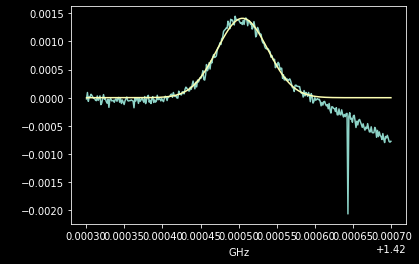

In [68]:
# nice fit!
pl.plot(frq[selection], blsub_powr[selection])
pl.plot(frq[selection], fitted_gaussian(frq[selection]))

Let's check the residual...

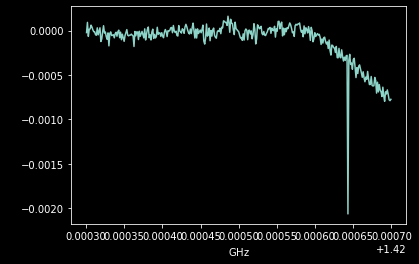

In [69]:
# flat residual, except for the dangling bit to the right
pl.plot(frq[selection], blsub_powr[selection] - fitted_gaussian(frq[selection]))

These were real data.  What did we measure?

In [70]:
velocity = (nu_hi - fitted_gaussian.mean) / nu_hi * constants.c
print(velocity.to(u.km/u.s))

-20.939818444407752 km / s


We measured a line-of-sight velocity of -20.9 km/s!  OK, good start.

In [71]:
temperature_measured = (fitted_gaussian.stddev**2 * constants.c**2 * hydrogen_mass / (nu_hi**2 * constants.k_B)).to(u.K)
print(temperature_measured)

5904.191409803261 K


We see a temperature of 5900 K.  Is that really the temperature?  Probably not, hydrogen is usually ionized at these temperatures, but we need to bring in outside information to know that for sure.

What about the intensity?  We don't know what that means yet - we have to calibrate the data first.

# Baselining - revisited

We fit a linear baseline model to the data.

Can we do better?  These guys clearly had to:
<img src="images/41550_2020_1174_Fig9_ESM.webp" style="max-height:500px">

We can try fitting functions like higher-order polynomials (e.g., $y = c_0 + c_1 x + c_2 x^2 + c_3 x^3 +...$), or we can try to fit splines or use Gaussian Processes or.... lots of other options.

But, what if we could skip all of that?

We can freely tune the spectrograph to whatever frequency we want.

Changing the frequency doesn't change the shape of the "baseline" (at least, not much).

## Frequency Switching

Frequency-switched observations are a great way to remove the baselines.  You measure them directly!

Frequency-switching is changing your target frequency by a little bit - a small fraction of the bandwidth - between observations.

In [72]:
# in our data, we observe at two frequencies...
frq1 = (tbl['freq1']*u.Hz).to(u.GHz)
frq2 = (tbl['freq2']*u.Hz).to(u.GHz)
(frq2-frq1).to(u.kHz)

<Quantity [-474., -474., -474., ..., -474., -474., -474.] kHz>

Our second observation is 474 kHz separated from the first one, or...

In [73]:
((frq2-frq1).to(u.kHz) / nu_hi * constants.c).to(u.km/u.s)

<Quantity [-100.04298067, -100.04298067, -100.04298067, ..., -100.04298067,
           -100.04298067, -100.04298067] km / s>

100 km/s.

# Frequency-switched spectra

With frequency-switched spectra, we subtract one spectrum from the other to get rid of the baselines.

In [74]:
pow1 = tbl['power1']
pow2 = tbl['power2']

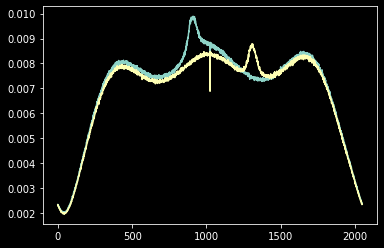

In [75]:
pl.plot(pow1)
pl.plot(pow2)

But we recognize that the data are taken at different frequencies.  Note that, when we plot against the observed frequency, the spectral line aligns:

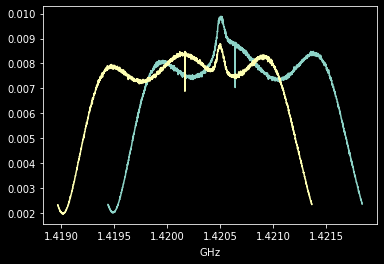

In [76]:
pl.plot(frq1, pow1)
pl.plot(frq2, pow2)

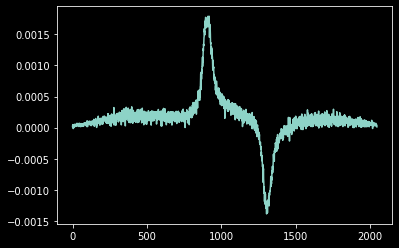

In [77]:
# our frequency-switched spectrum:
pl.plot(pow1-pow2)

The frequency-switched spectrum has both a negative and a positive component!

Recall that we measured the line at -20 km/s.  That's the positive one.  The negative bit shows up at the "wrong" frequency, but we know exactly where it is (it's wrong by 100 km/s)

This new spectrum has a super nice, flat profile.  It's not *perfect*, but it's good

(-0.0001, 0.0004)

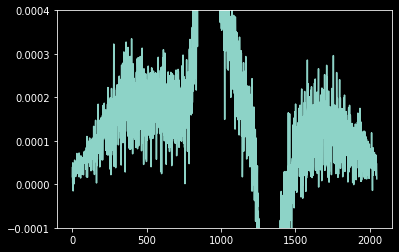

In [78]:
pl.plot(pow1-pow2)
pl.ylim(-0.0001,0.0004)

We can now fit to this spectrum:

In [79]:
fsw_pow = pow1 - pow2
fitted_gaussian = fitter(guess_gaussian, frq1[selection], fsw_pow[selection])
fitted_gaussian

<Gaussian1D(amplitude=0.00150347, mean=1.42051139 GHz, stddev=0.00005926 GHz)>

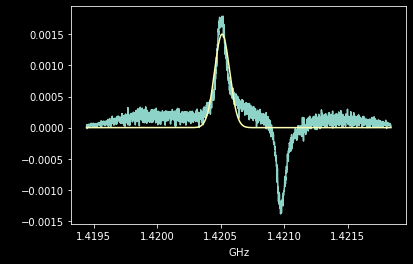

In [80]:
pl.plot(frq1, fsw_pow)
pl.plot(frq1, fitted_gaussian(frq1))

In [81]:
guess_gaussian.mean = 1.42099*u.GHz
guess_gaussian.amplitude = -0.0015
fitted_gaussian = fitter(guess_gaussian, frq1, fsw_pow)
fitted_gaussian

<Gaussian1D(amplitude=-0.00124219, mean=1.42098092 GHz, stddev=0.0000352 GHz)>

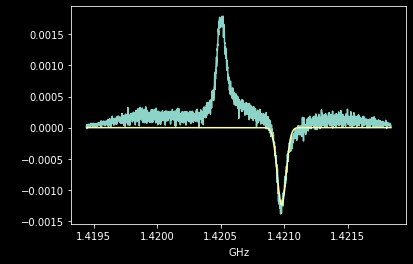

In [82]:
pl.plot(frq1, fsw_pow)
pl.plot(frq1, fitted_gaussian(frq1))

# Frequency Switching

We can average these lines together to get a signal-to-noise boost of $\sqrt{2}$.

The advantages of frequency switching are clear: it gets rid of "baselines"!

It can fail, though: If your target line is too broad, you have to do a big frequency switch to prevent the positive and negative parts from overlapping.

The further apart your two observations are (in frequency or in time), the worse the baseline subtraction will be; baselines vary with time, frequency, and sometimes even with the intensity of the source you're looking at.  The sun will probably produce slightly differently-shaped baselines than off-sun.

# Uncertainty and noise

We have gotten this far with our real data without talking about the noise.  How do we infer it?

Generally, we can only estimate the pixel-to-pixel variation in the spectrum, or the spectrum-to-spectrum variation.  We have to estimate the noise, we can't compute it from first principles because there are too many unknowns about the system.

# Measuring the uncertainty

We can simply take a signal-free portion of the spectrum and use it to infer the local noise by taking the standard deviation:

(<Quantity 1.4196 GHz>, <Quantity 1.4204 GHz>, 0, 0.0005)

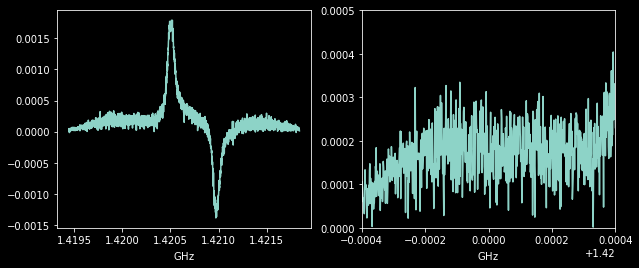

In [83]:
pl.figure(figsize=(10,4))
pl.subplot(1,2,1).plot(frq1, fsw_pow)
pl.subplot(1,2,2).plot(frq1, fsw_pow)
pl.axis((1.4196*u.GHz, 1.4204*u.GHz, 0, 0.0005))

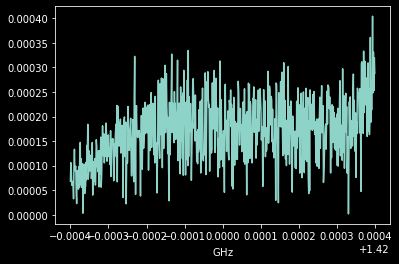

In [84]:
selection_for_noise = (frq1 > 1.4196*u.GHz) & (frq1 < 1.4204*u.GHz)
pl.plot(frq1[selection_for_noise], fsw_pow[selection_for_noise])

In [85]:
noise_estimate2 = np.std(fsw_pow[selection_for_noise])
print(noise_estimate2)

6.539806569313538e-05


We can use this noise estimate when computing our fit and errors on the fit and thereby get error estimates on the fit parameters:

In [86]:
guess_gaussian = Gaussian1D(amplitude=0.0015, mean=1.4205*u.GHz, stddev=0.0001*u.GHz)
fitted_gaussian = fitter(guess_gaussian, frq1[selection], fsw_pow[selection], weights=1/noise_estimate2)
fitted_gaussian

<Gaussian1D(amplitude=0.00150217, mean=1.42051142 GHz, stddev=0.00005936 GHz)>

In [87]:
print(f"Centroid is {fitted_gaussian.mean.value} +/- {fitter.fit_info['param_cov'][1,1]**0.5}")
print(f"Width is {fitted_gaussian.stddev.value} +/- {fitter.fit_info['param_cov'][2,2]**0.5}")

Centroid is 1.4205114157607268 +/- 1.1863294858408722e-06
Width is 5.935906597883401e-05 +/- 1.1868086392405973e-06


# Estimating uncertainty
But be wary!  If you have a non-flat baseline, you cannot estimate uncertainty this way!

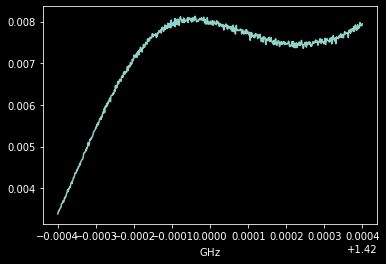

In [88]:
pl.plot(frq1[selection_for_noise], pow1[selection_for_noise])

In [89]:
print(f"The non-fsw measurement has a standard deviation={pow1[selection_for_noise].std():0.4f}, "
      f"which is much bigger than the fsw measurement {fsw_pow[selection_for_noise].std():0.4g}")

The non-fsw measurement has a standard deviation=0.0012, which is much bigger than the fsw measurement 6.54e-05


FIN for now

The numerator of the  $m_1$ equation is $$\Sigma \nu S_\nu \Delta \nu$$.

We take advantage of the propagation of errors for sums $$\sigma^2(\Sigma x_i) = \Sigma \sigma_{x_i}^2$$ to write the error on the numerator as

$$ \sigma_{numerator}^2 = \Sigma (\nu-m_1)^2 \sigma_S^2 (\Delta \nu)^2 $$


In [27]:
# estimate of the temperature and uncertainty on the temperature
noisy_temperature_measured = (noisy_moment2 * constants.c**2 * hydrogen_mass / (nu_hi**2 * constants.k_B)).to(u.K)
noisy_temperature_uncertainty = (noisy_moment2_uncertainty * constants.c**2 * hydrogen_mass / (nu_hi**2 * constants.k_B)).to(u.K)
print(f"T = {noisy_temperature_measured:0.1f} +/- {noisy_temperature_uncertainty:0.1f}")

T = 133.9 K +/- 30.7 K


# Moment Analysis - baselines

Where can moment analysis go really wrong?

If you have a background continuum, none of this works!  We call removing the continuum "baseline subtraction".

We'll dig into baselines more now as it's important for the cases we're dealing with.

(-0.2, 2.5)

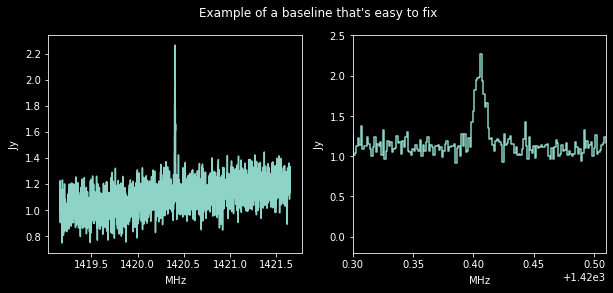

In [28]:
noisy_baseline_model_profile = noisy_model_profile + np.poly1d([0.0001,1],r=False)(np.arange(frequency_axis.size))*noisy_model_profile.unit
pl.figure(figsize=(10,4))
pl.suptitle("Example of a baseline that's easy to fix")
pl.subplot(1,2,1).plot(frequency_axis, noisy_baseline_model_profile,
        drawstyle='steps-mid')
pl.subplot(1,2,2).plot(frequency_axis, noisy_baseline_model_profile,
        drawstyle='steps-mid')
pl.xlim(1420.3,1420.51)
pl.ylim(-0.2,2.5)


Why is the baseline a problem?
$$ m_0 = \Sigma  S_\nu \Delta \nu $$
$$ m_1 = \frac{\Sigma \nu S_\nu \Delta \nu}{m_0} $$
$$ m_2 = \frac{\Sigma \nu^2 S_\nu \Delta \nu}{m_0} $$
All of these moments include the flux at each pixel, so if there's a gradient in the flux, it biases the measurement.

In [29]:
# hackery to make a bad baseline example
# (you don't need to pay close attention to this for now)
np.random.seed(2)
x = np.poly1d([1,2,3] + list(np.random.randn(25)))(np.linspace(-5,5,frequency_axis.size))
x = np.abs(np.fft.fft(x)) / x.sum()
x[0:18] = 0
bad_baseline = np.abs(np.fft.fft(x)) * model_line_profile.unit
noisy_bad_baseline_model_profile = noisy_model_profile + bad_baseline

# Real Bad Baselines

In real life, bad baselines can be really bad, and important (and difficult) to deal with...

<img src="images/41550_2020_1174_Fig9_ESM.webp">

(-0.2, 2.0)

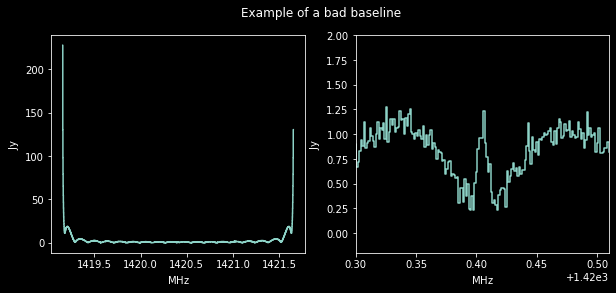

In [30]:
pl.figure(figsize=(10,4))
pl.suptitle("Example of a bad baseline")
pl.subplot(1,2,1).plot(frequency_axis, noisy_bad_baseline_model_profile,
        drawstyle='steps-mid')
pl.subplot(1,2,2).plot(frequency_axis, noisy_bad_baseline_model_profile,
        drawstyle='steps-mid')
pl.xlim(1420.3,1420.51)
pl.ylim(-0.2,2.)


## What do we do about bad baselines?

Generally, we try to model and remove them.  

This can be difficult and can result in fake features in the data, so it helps to know what fake features look like.


When you take spectra with the resistor attached, or with the antenna not attached, it is telling you what the instrumental features look like.

Text(0.5, 1.0, 'Example of a spectrum with a bad baseline from our data')

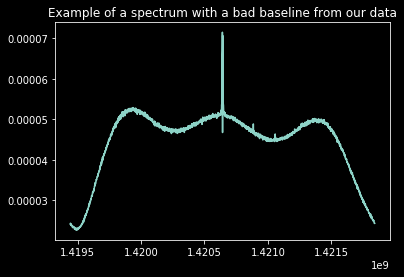

In [31]:
from astropy import table
tbl = table.Table.read('data/psd_200918_140757_tint60s_sdr0_fsw50ohm_on_calibration_60s.fits')
pl.plot(tbl['freq1'], tbl['power1'])
pl.title("Example of a spectrum with a bad baseline from our data")

We're just noting baselines as a problem now - we'll come back to how to subtract them in a few slides.

# Model Fitting

The next level approach is to fit a model to the data.

Our model is a "predictive" or "generative" model.

When fitting the model to data, in the "classical" approach, we treat the uncertainty-per-pixel as a weight.

Text(0.5, 1.0, 'A line profile with errorbars')

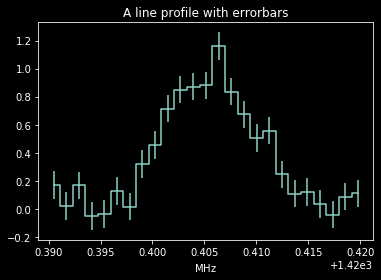

In [32]:
# a line profile with errorbars on the data points
pl.errorbar(frequency_axis[selection], noisy_model_profile[selection].value,
            drawstyle='steps-mid', yerr=noise_estimate.value)
pl.title("A line profile with errorbars")

# Model Fitting

Astropy provides the tools for this.  Programming your own fitting (optimization) routine is very challenging, so we use existing libraries.

https://docs.astropy.org/en/stable/modeling/

# Model Fitting

Our emission line is expected to be a Gaussian, so we adopt that model.

In [33]:
from astropy.modeling.models import Gaussian1D

We have to start our modeling from a guess.  We'll use our moment-based guesses as the inputs:

In [34]:
# create a Gaussian model
guess_gaussian = Gaussian1D(amplitude=noisy_model_profile.max(),
                            mean=noisy_moment1,
                            stddev=noisy_sigma
                           )
guess_gaussian

<Gaussian1D(amplitude=1.16129091 Jy, mean=1420.40551509 MHz, stddev=0.00499935 MHz)>

# Using models

We can evaluate our model by using it as a function: `guess_gaussian(frequency)` will give us a new model:

Text(0.5, 1.0, 'our Gaussian model plotted on top of the data')

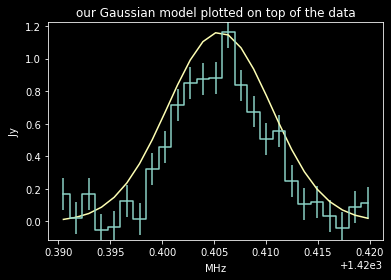

In [35]:
pl.errorbar(frequency_axis[selection], noisy_model_profile[selection].value,
            drawstyle='steps-mid', yerr=noise_estimate.value)
pl.plot(frequency_axis[selection], guess_gaussian(frequency_axis[selection]))
pl.title("our Gaussian model plotted on top of the data")

# Fitting

We now want to *fit* the model: we want to use an automated algorithm to find the best-matching set of parameters for the Gaussian.

In [36]:
# import the Levenberg-Marquardt Least Squares Model Fitter
from astropy.modeling.fitting import LevMarLSQFitter
fitter = LevMarLSQFitter()
fitted_gaussian = fitter(guess_gaussian, frequency_axis, noisy_model_profile,
                         weights=1/noise_estimate)
fitted_gaussian

<Gaussian1D(amplitude=1.00337362 Jy, mean=1420.40555747 MHz, stddev=0.00418435 MHz)>

# Fitting
Now that we've found the fit, let's look at how well it did:

(1420.36, 1420.45)

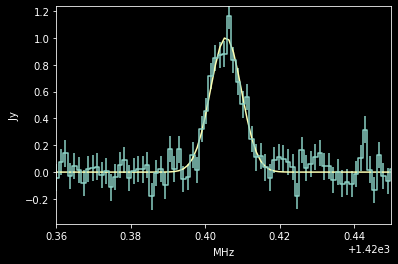

In [37]:
pl.errorbar(frequency_axis, noisy_model_profile.value,
            drawstyle='steps-mid', yerr=noise_estimate.value)
pl.plot(frequency_axis, fitted_gaussian(frequency_axis))
pl.xlim(1420.36,1420.45)

# Fitting: Good enough?

How do we determine if the fit is good enough?  One good way is to look at the residuals.

Residuals are the *data* minus the *model*:

In [38]:
model = fitted_gaussian(frequency_axis)

residual = noisy_model_profile - model

(1420.36, 1420.45)

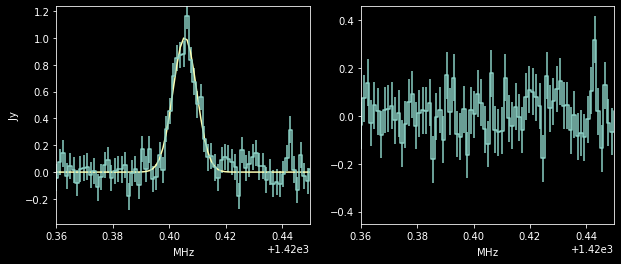

In [39]:
pl.figure(figsize=(10,4))
pl.subplot(1,2,1).errorbar(frequency_axis, noisy_model_profile.value,
            drawstyle='steps-mid', yerr=noise_estimate.value)
pl.plot(frequency_axis, fitted_gaussian(frequency_axis))
pl.xlim(1420.36,1420.45)
pl.subplot(1,2,2).errorbar(frequency_axis, residual.value,
            drawstyle='steps-mid', yerr=noise_estimate.value)
pl.xlim(1420.36,1420.45)

# Uncertainty?

The Levenberg-Marquardt fitter gives us an estimate of the parameter uncertainty too, via the covariance matrix:

In [40]:
print(fitter.fit_info['param_cov'])

[[ 2.36438876e-03  1.01223102e-17 -6.56925099e-06]
 [ 1.01223102e-17  5.47562981e-08 -2.98060611e-20]
 [-6.56925099e-06 -2.98060611e-20  5.47562981e-08]] 1 / Jy2


The diagonal of this matrix is the variance of the *amplitude*, *mean* (centroid, moment 1), and *Gaussian standard deviation* (sigma, width):

In [41]:
print(f"Peak is {fitted_gaussian.amplitude.value} +/-"
      f" {fitter.fit_info['param_cov'][0,0].value**0.5}")

Peak is 1.0033736158788507 +/- 0.04862498079580134


In [42]:
print(f"Centroid is {fitted_gaussian.mean.value} +/-"
      f" {fitter.fit_info['param_cov'][1,1].value**0.5}")

Centroid is 1420.4055574725355 +/- 0.00023400063696660042


In [43]:
print(f"Width is {fitted_gaussian.stddev.value} +/-"
      f" {fitter.fit_info['param_cov'][2,2].value**0.5}")

Width is 0.004184349993521919 +/- 0.00023400063696731637


# How do these compare to the moment-based fits?

Close, but not exact.

In [44]:
print(f"Centroid is {fitted_gaussian.mean.value:0.5f} +/- {fitter.fit_info['param_cov'][1,1]**0.5:0.5f}")
print(f"Width is {fitted_gaussian.stddev.value:0.5f} +/- {fitter.fit_info['param_cov'][2,2]**0.5:0.5f}")
print()
print(f"m1 = {noisy_moment1:0.5f} +/- {noisy_moment1_uncertainty:0.5f}")
print(f"sqrt(m2) = {noisy_moment2**0.5:0.5f} +/- {noisy_moment2_uncertainty**0.5:0.5f}")

Centroid is 1420.40556 +/- 0.00023 1 / Jy
Width is 0.00418 +/- 0.00023 1 / Jy

m1 = 1420.40552 MHz +/- 0.00049 MHz
sqrt(m2) = 0.00500 MHz +/- 0.00239 MHz


# Model Fitting - How do we handle baselines?

I noted above that bad baselines are an issue.  

For most baseline problems, you can select down a local region and fit a line around that

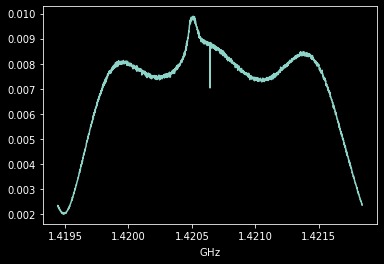

In [45]:
# our data
tbl = table.Table.read('data/psd_200725_100309_tint60s_sdr0_fsw.fits')
frq = (tbl['freq1']*u.Hz).to(u.GHz)
powr = tbl['power1']
pl.plot(frq, powr)

(<Quantity 1.42025 GHz>, <Quantity 1.4207 GHz>, 0.007, 0.01)

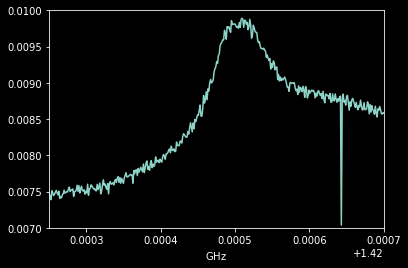

In [46]:
# zoom in on the line
pl.plot(frq.to(u.GHz), powr)
pl.axis((1.42025*u.GHz, 1.4207*u.GHz, 0.007, 0.01))

We can eyeball a linear fit to this.... it won't be good, but it will be OK:

(<Quantity 1.42025 GHz>, <Quantity 1.4207 GHz>, 0.007, 0.01)

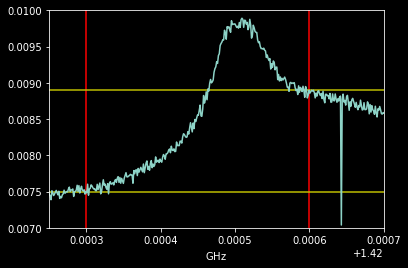

In [47]:
# let's find some approximate positions that are not part of the line...
pl.plot(frq.to(u.GHz), powr)
pl.vlines([1.4203, 1.4206]*u.GHz, 0.007, 0.01, color='r')
pl.hlines([0.0075, 0.0089], 1.42025*u.GHz, 1.4207*u.GHz, color='y')
pl.axis((1.42025*u.GHz, 1.4207*u.GHz, 0.007, 0.01))

Two points make a line... ($y = m x + b$)

In [48]:
slope = (0.0089 - 0.0075) / ((1.4206 - 1.4203)*u.GHz)
intercept = 0.0089 - slope * 1.4206*u.GHz
baseline_model = frq*slope + intercept

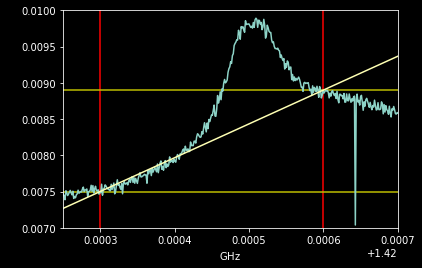

In [49]:
# show our "fit"
pl.plot(frq.to(u.GHz), powr)
pl.vlines([1.4203, 1.4206]*u.GHz, 0.007, 0.01, color='r')
pl.hlines([0.0075, 0.0089], 1.42025*u.GHz, 1.4207*u.GHz, color='y')
pl.axis((1.42025*u.GHz, 1.4207*u.GHz, 0.007, 0.01))
pl.plot(frq, baseline_model)

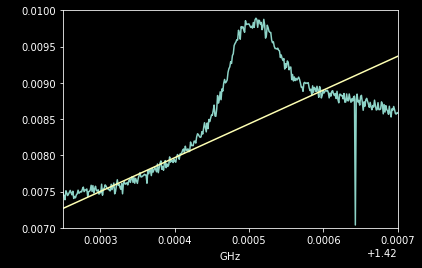

In [50]:
pl.plot(frq.to(u.GHz), powr)
pl.axis((1.42025*u.GHz, 1.4207*u.GHz, 0.007, 0.01))
pl.plot(frq, baseline_model)

We can now remove the baseline and see how that looks...

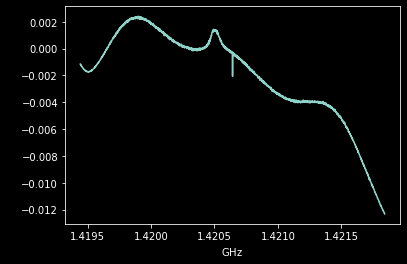

In [51]:
# Overall, this looks kinda bad....
blsub_powr = powr - baseline_model
pl.plot(frq.to(u.GHz), blsub_powr)

(-0.002, 0.002)

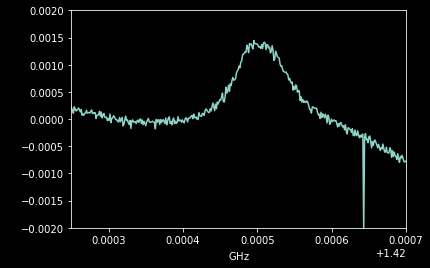

In [52]:
# but if we zoom in, hey, not so bad!!
pl.plot(frq.to(u.GHz), blsub_powr)
pl.xlim(1.42025*u.GHz, 1.4207*u.GHz)
pl.ylim(-0.002, 0.002)

We can fit a Gaussian to this now (we could not have before!!)

We need to put in some guesses.  This time, we'll eyeball them again...

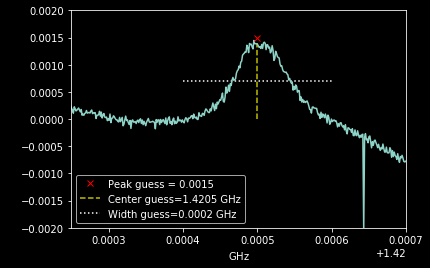

In [53]:
pl.plot(frq.to(u.GHz), blsub_powr)
pl.xlim(1.42025*u.GHz, 1.4207*u.GHz)
pl.ylim(-0.002, 0.002)
pl.plot(1.4205*u.GHz, 0.0015, 'rx', label='Peak guess = 0.0015')
pl.vlines(1.4205*u.GHz, 0, 0.0014, color='y', linestyle='--', label='Center guess=1.4205 GHz')
pl.hlines(0.0007, 1.4204*u.GHz, 1.4206*u.GHz, color='w', linestyle=':', label="Width guess=0.0002 GHz")
pl.legend(loc='best')

In [54]:
guess_gaussian = Gaussian1D(amplitude=0.0015,
                            mean=1.4205*u.GHz,
                            stddev=0.0002*u.GHz,
                           )
guess_gaussian

<Gaussian1D(amplitude=0.0015, mean=1.4205 GHz, stddev=0.0002 GHz)>

In [55]:
fitted_gaussian = fitter(guess_gaussian, frq, blsub_powr)
fitted_gaussian

<Gaussian1D(amplitude=0.00074854 , mean=1.42024623 GHz, stddev=0. GHz)>

(-0.002, 0.002)

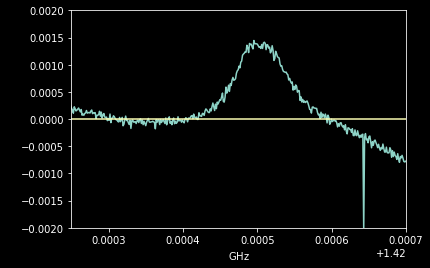

In [56]:
# uh oh! no good!
pl.plot(frq.to(u.GHz), blsub_powr)
pl.plot(frq, fitted_gaussian(frq))
pl.xlim(1.42025*u.GHz, 1.4207*u.GHz)
pl.ylim(-0.002, 0.002)

Because so much of the spectrum is not good - we only have a decent linear baseline near the line - we need to exclude the rest.  This is the "data selection" approach from before

In [57]:
selection = (frq > 1.4203*u.GHz) & (frq < 1.4207*u.GHz)

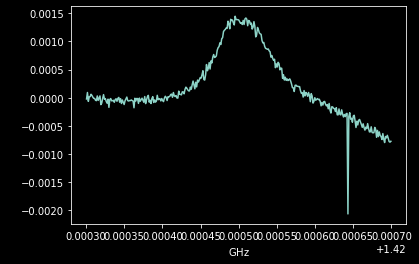

In [58]:
pl.plot(frq[selection], blsub_powr[selection])

In [59]:
guess_gaussian

<Gaussian1D(amplitude=0.0015, mean=1.4205 GHz, stddev=0.0002 GHz)>

In [60]:
fitted_gaussian = fitter(guess_gaussian, frq[selection], blsub_powr[selection])
fitted_gaussian

<Gaussian1D(amplitude=0.00075683 , mean=1.42046677 GHz, stddev=0. GHz)>

Wait, it still didn't work?  What's going wrong now?

Well,  lets look at our guess:

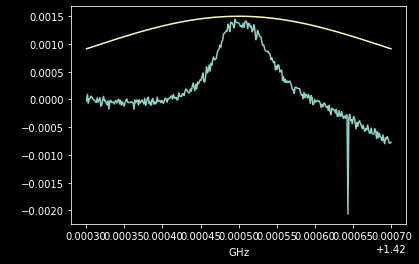

In [61]:
pl.plot(frq[selection], blsub_powr[selection])
pl.plot(frq[selection], guess_gaussian(frq[selection]))

The guess is clearly too wide!  I actually made a mistake - the width we were supposed to guess is 0.0001 GHz, not 0.0002!

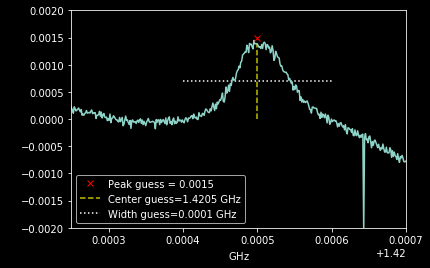

In [62]:
# This is where I overestimated the width: I put in 0.0002,
# which is the *full width*, but the guess is the *half-width*
pl.plot(frq.to(u.GHz), blsub_powr)
pl.xlim(1.42025*u.GHz, 1.4207*u.GHz)
pl.ylim(-0.002, 0.002)
pl.plot(1.4205*u.GHz, 0.0015, 'rx', label='Peak guess = 0.0015')
pl.vlines(1.4205*u.GHz, 0, 0.0014, color='y', linestyle='--', label='Center guess=1.4205 GHz')
pl.hlines(0.0007, 1.4204*u.GHz, 1.4206*u.GHz, color='w', linestyle=':', label="Width guess=0.0001 GHz")
pl.legend(loc='best')

In [63]:
guess_gaussian = Gaussian1D(amplitude=0.0015,
                            mean=1.4205*u.GHz,
                            stddev=0.0001*u.GHz,
                           )
guess_gaussian

<Gaussian1D(amplitude=0.0015, mean=1.4205 GHz, stddev=0.0001 GHz)>

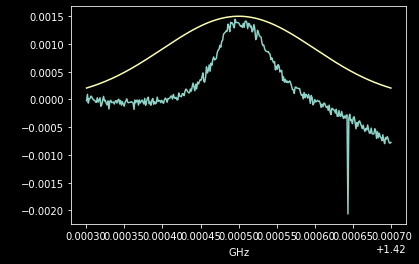

In [64]:
pl.plot(frq[selection], blsub_powr[selection])
pl.plot(frq[selection], guess_gaussian(frq[selection]))

Still a bit wide... 

In [65]:
guess_gaussian = Gaussian1D(amplitude=0.0015,
                            mean=1.4205*u.GHz,
                            stddev=0.00005*u.GHz,
                           )
guess_gaussian

<Gaussian1D(amplitude=0.0015, mean=1.4205 GHz, stddev=0.00005 GHz)>

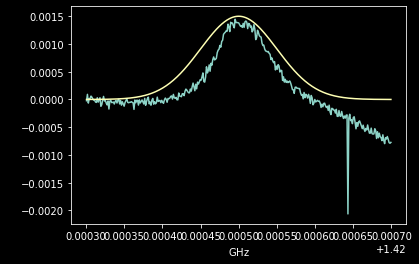

In [66]:
pl.plot(frq[selection], blsub_powr[selection])
pl.plot(frq[selection], guess_gaussian(frq[selection]))

Now that the guess is reasonably close, we can try to fit again...

In [67]:
fitted_gaussian = fitter(guess_gaussian, frq[selection], blsub_powr[selection])
fitted_gaussian

<Gaussian1D(amplitude=0.00140884 , mean=1.42050496 GHz, stddev=0.0000332 GHz)>

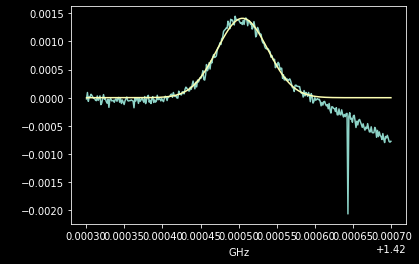

In [68]:
# nice fit!
pl.plot(frq[selection], blsub_powr[selection])
pl.plot(frq[selection], fitted_gaussian(frq[selection]))

Let's check the residual...

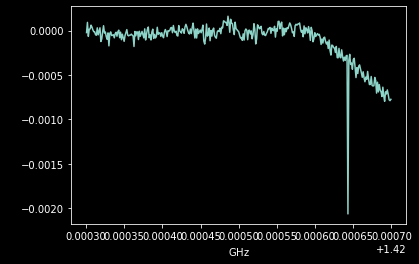

In [69]:
# flat residual, except for the dangling bit to the right
pl.plot(frq[selection], blsub_powr[selection] - fitted_gaussian(frq[selection]))

These were real data.  What did we measure?

In [70]:
velocity = (nu_hi - fitted_gaussian.mean) / nu_hi * constants.c
print(velocity.to(u.km/u.s))

-20.939818444407752 km / s


We measured a line-of-sight velocity of -20.9 km/s!  OK, good start.

In [71]:
temperature_measured = (fitted_gaussian.stddev**2 * constants.c**2 * hydrogen_mass / (nu_hi**2 * constants.k_B)).to(u.K)
print(temperature_measured)

5904.191409803261 K


We see a temperature of 5900 K.  Is that really the temperature?  Probably not, hydrogen is usually ionized at these temperatures, but we need to bring in outside information to know that for sure.

What about the intensity?  We don't know what that means yet - we have to calibrate the data first.

# Baselining - revisited

We fit a linear baseline model to the data.

Can we do better?  These guys clearly had to:
<img src="images/41550_2020_1174_Fig9_ESM.webp" style="max-height:500px">

We can try fitting functions like higher-order polynomials (e.g., $y = c_0 + c_1 x + c_2 x^2 + c_3 x^3 +...$), or we can try to fit splines or use Gaussian Processes or.... lots of other options.

But, what if we could skip all of that?

We can freely tune the spectrograph to whatever frequency we want.

Changing the frequency doesn't change the shape of the "baseline" (at least, not much).

## Frequency Switching

Frequency-switched observations are a great way to remove the baselines.  You measure them directly!

Frequency-switching is changing your target frequency by a little bit - a small fraction of the bandwidth - between observations.

In [72]:
# in our data, we observe at two frequencies...
frq1 = (tbl['freq1']*u.Hz).to(u.GHz)
frq2 = (tbl['freq2']*u.Hz).to(u.GHz)
(frq2-frq1).to(u.kHz)

<Quantity [-474., -474., -474., ..., -474., -474., -474.] kHz>

Our second observation is 474 kHz separated from the first one, or...

In [73]:
((frq2-frq1).to(u.kHz) / nu_hi * constants.c).to(u.km/u.s)

<Quantity [-100.04298067, -100.04298067, -100.04298067, ..., -100.04298067,
           -100.04298067, -100.04298067] km / s>

100 km/s.

# Frequency-switched spectra

With frequency-switched spectra, we subtract one spectrum from the other to get rid of the baselines.

In [74]:
pow1 = tbl['power1']
pow2 = tbl['power2']

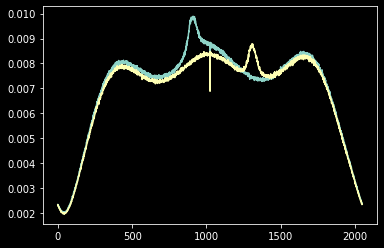

In [75]:
pl.plot(pow1)
pl.plot(pow2)

But we recognize that the data are taken at different frequencies.  Note that, when we plot against the observed frequency, the spectral line aligns:

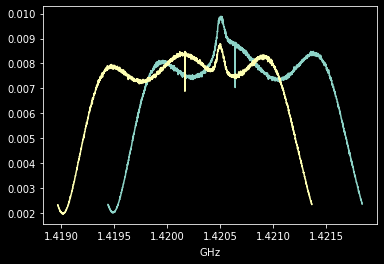

In [76]:
pl.plot(frq1, pow1)
pl.plot(frq2, pow2)

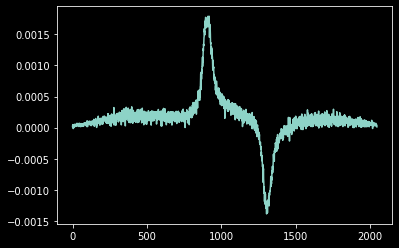

In [77]:
# our frequency-switched spectrum:
pl.plot(pow1-pow2)

The frequency-switched spectrum has both a negative and a positive component!

Recall that we measured the line at -20 km/s.  That's the positive one.  The negative bit shows up at the "wrong" frequency, but we know exactly where it is (it's wrong by 100 km/s)

This new spectrum has a super nice, flat profile.  It's not *perfect*, but it's good

(-0.0001, 0.0004)

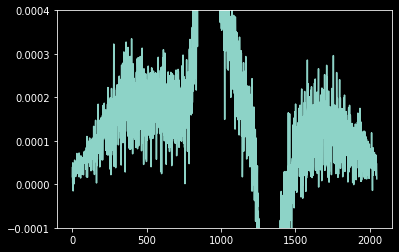

In [78]:
pl.plot(pow1-pow2)
pl.ylim(-0.0001,0.0004)

We can now fit to this spectrum:

In [79]:
fsw_pow = pow1 - pow2
fitted_gaussian = fitter(guess_gaussian, frq1[selection], fsw_pow[selection])
fitted_gaussian

<Gaussian1D(amplitude=0.00150347, mean=1.42051139 GHz, stddev=0.00005926 GHz)>

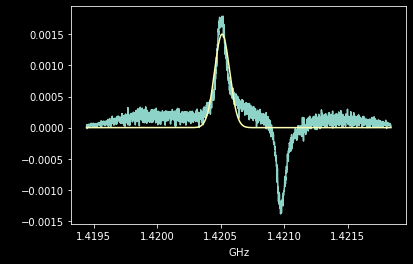

In [80]:
pl.plot(frq1, fsw_pow)
pl.plot(frq1, fitted_gaussian(frq1))

In [81]:
guess_gaussian.mean = 1.42099*u.GHz
guess_gaussian.amplitude = -0.0015
fitted_gaussian = fitter(guess_gaussian, frq1, fsw_pow)
fitted_gaussian

<Gaussian1D(amplitude=-0.00124219, mean=1.42098092 GHz, stddev=0.0000352 GHz)>

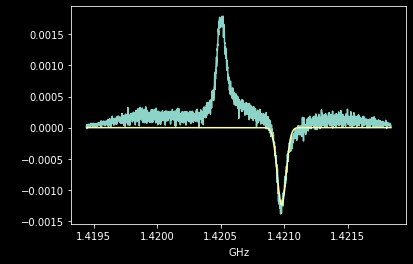

In [82]:
pl.plot(frq1, fsw_pow)
pl.plot(frq1, fitted_gaussian(frq1))

# Frequency Switching

We can average these lines together to get a signal-to-noise boost of $\sqrt{2}$.

The advantages of frequency switching are clear: it gets rid of "baselines"!

It can fail, though: If your target line is too broad, you have to do a big frequency switch to prevent the positive and negative parts from overlapping.

The further apart your two observations are (in frequency or in time), the worse the baseline subtraction will be; baselines vary with time, frequency, and sometimes even with the intensity of the source you're looking at.  The sun will probably produce slightly differently-shaped baselines than off-sun.

# Uncertainty and noise

We have gotten this far with our real data without talking about the noise.  How do we infer it?

Generally, we can only estimate the pixel-to-pixel variation in the spectrum, or the spectrum-to-spectrum variation.  We have to estimate the noise, we can't compute it from first principles because there are too many unknowns about the system.

# Measuring the uncertainty

We can simply take a signal-free portion of the spectrum and use it to infer the local noise by taking the standard deviation:

(<Quantity 1.4196 GHz>, <Quantity 1.4204 GHz>, 0, 0.0005)

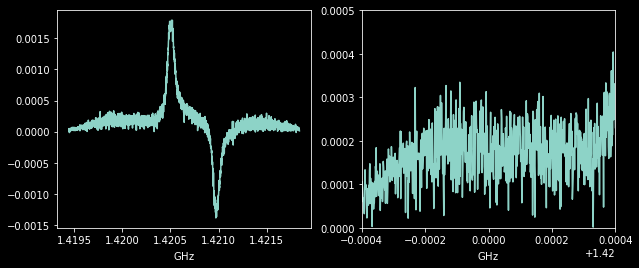

In [83]:
pl.figure(figsize=(10,4))
pl.subplot(1,2,1).plot(frq1, fsw_pow)
pl.subplot(1,2,2).plot(frq1, fsw_pow)
pl.axis((1.4196*u.GHz, 1.4204*u.GHz, 0, 0.0005))

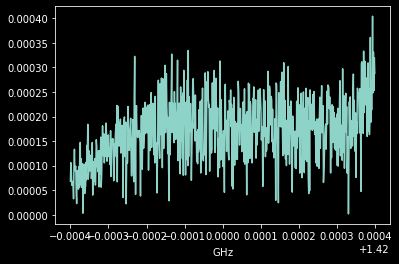

In [84]:
selection_for_noise = (frq1 > 1.4196*u.GHz) & (frq1 < 1.4204*u.GHz)
pl.plot(frq1[selection_for_noise], fsw_pow[selection_for_noise])

In [85]:
noise_estimate2 = np.std(fsw_pow[selection_for_noise])
print(noise_estimate2)

6.539806569313538e-05


We can use this noise estimate when computing our fit and errors on the fit and thereby get error estimates on the fit parameters:

In [86]:
guess_gaussian = Gaussian1D(amplitude=0.0015, mean=1.4205*u.GHz, stddev=0.0001*u.GHz)
fitted_gaussian = fitter(guess_gaussian, frq1[selection], fsw_pow[selection], weights=1/noise_estimate2)
fitted_gaussian

<Gaussian1D(amplitude=0.00150217, mean=1.42051142 GHz, stddev=0.00005936 GHz)>

In [87]:
print(f"Centroid is {fitted_gaussian.mean.value} +/- {fitter.fit_info['param_cov'][1,1]**0.5}")
print(f"Width is {fitted_gaussian.stddev.value} +/- {fitter.fit_info['param_cov'][2,2]**0.5}")

Centroid is 1.4205114157607268 +/- 1.1863294858408722e-06
Width is 5.935906597883401e-05 +/- 1.1868086392405973e-06


# Estimating uncertainty
But be wary!  If you have a non-flat baseline, you cannot estimate uncertainty this way!

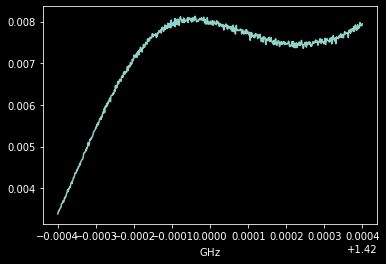

In [88]:
pl.plot(frq1[selection_for_noise], pow1[selection_for_noise])

In [89]:
print(f"The non-fsw measurement has a standard deviation={pow1[selection_for_noise].std():0.4f}, "
      f"which is much bigger than the fsw measurement {fsw_pow[selection_for_noise].std():0.4g}")

The non-fsw measurement has a standard deviation=0.0012, which is much bigger than the fsw measurement 6.54e-05


FIN for now